<a href="https://colab.research.google.com/github/HadarRosenwald/severity-detection/blob/main/TabularModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!pip -q install torchxrayvision
!pip -q install image_tabular

In [120]:
# torch.__version__

In [121]:
import matplotlib.pyplot as plt
import os
import shutil
import torch
import torchxrayvision as xrv
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import fastai
from fastai.tabular.data import TabularList
import image_tabular as imtab
from sklearn.model_selection import train_test_split
import math


from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

In [122]:
!rm -rf covid-chestxray-dataset

In [123]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 35.33 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


# **Configurations**

In [124]:
# data split
test_pct=0.2
valid_pct=0.2

# models param
##TAB
tab_out_sz = 18 # output size that will be concatenated with the CNN, same output size
dropout_prob_tab = 0.2
tab_layers = [100, 200] # the sizes of the hidden fully connected layers between the input (after embedding) and before the classification layer. The number of hidden layers is determined by the length of the list.
# TODO: tune this, for our data size, [100,200] seems highly overfitted. according to the rule of thumb bellow, we should have 0
# https://forums.fast.ai/t/an-attempt-to-find-the-right-hidden-layer-size-for-your-tabular-learner/45714
# len_train = 110; alpha = 2; n_input=8; n_output=18; io=n_input+n_output; numHiddenLayers=2
# tab_layers = [(len_train//(alpha*(io)))//numHiddenLayers]*numHiddenLayers

##CNN
cnn_out_sz = 18 # following xrv.models.DenseNet output layer
image_size = 224 # to fit xrv.models.DenseNet
# image_resize_method = ResizeMethod.SQUISH
image_convert_mode = 'L' #for greyscale

##CNN_TAB
cnn_tabular_dropout_prob = 0.2
cnn_tabular_layers = [cnn_out_sz + tab_out_sz, 32]
cnn_tabular_out_sz = 5 #number of classes
batch_size = 64
n_epoch = 2


# misc
seed=42
data_path = Path("./covid-chestxray-dataset/")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Creating label**

In [125]:
def generate_label(x):
    # no data
    if np.all(pd.isna([x.survival, x.intubated, x.went_icu, x.needed_supplemental_O2])):
        return np.NaN

    # didn't survive
    if x.survival=='N':
        return '4'

    #either survived or survival is unknown
    if x.intubated == 'Y':
        return '3'
    if x.survival=='Y':
        if x.went_icu == 'Y' or x.needed_supplemental_O2 == 'Y':
            return '1'
    if x.went_icu == 'Y' or x.needed_supplemental_O2 == 'Y':
        return '2'
    return '0'

In [126]:
metadata = d.csv
metadata['severity_class']=metadata.apply(generate_label, axis=1)

# **Tabular Data handling**

## **Avoiding confounders**

In [127]:
filtered_metadata = metadata.loc[(metadata.view!="APS") & (metadata.offset>=0) & (metadata.offset<=8) & (metadata.intubation_present != 'Y') & (metadata.in_icu != 'Y')]
filtered_metadata = filtered_metadata[['index','patientid','sex','age','RT_PCR_positive','temperature','pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'severity_class' ,'filename']]

## **Handling missing data**

In [128]:
filtered_metadata = filtered_metadata.dropna(subset=['severity_class'], how='any')

In [129]:
filtered_metadata.head()

,index,patientid,sex,age,RT_PCR_positive,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,severity_class,filename
0,0,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,1,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,2,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,3,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,4,4,F,52.0,Y,NaN,NaN,NaN,NaN,NaN,0,nejmc2001573_f1a.jpeg


## **Train test and validation split**

In [130]:
train_df, test_df = train_test_split(filtered_metadata, test_size=test_pct)

# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df, valid_pct=valid_pct, seed=seed)

## **Preparing fastai LabelLists**

### **Features**

In [131]:
# Features with categorical values
cat_names = ['sex', 'RT_PCR_positive']

# Features with continious values
cont_names = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']

### **Labels**

In [132]:
# Target
dep_var = ['severity_class']

### **Ensambling the tabular dataset**

In [133]:
procs = [FillMissing, Categorify, Normalize] # <- TODO Understand how does FillMissing work. without it- it doesnt work + understand why it changed the categorial from 2 to 8 (x[1][0].shape)
# procs = [Categorify, Normalize]

tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var))

test_tab_data = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, processor=tab_data.train.x.processor)
tab_data = tab_data.add_test(test_tab_data)

In [134]:
# Iterating over tab_data items, printing class name and items len, using 
# `show_some()` to return the representation of the first 5 elements in `items`.
tab_data
# Note that the Test LabelList has no labels. Like in Kaggle competitions. This was changes in fastai 2. Look here: https://forums.fast.ai/t/empty-label-list-for-test-dataset-using-from-folder/57100

LabelLists;

Train: LabelList (88 items)
x: TabularList
sex F; RT_PCR_positive #na#; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age -2.0967; temperature 0.0644; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature_na False; pO2_saturation_na False; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age -1.2513; temperature -2.7682; pO2_saturation 1.0259; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.8622; temperature 0.0644; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature

### one example from the tabular data

In [135]:
print(f"features: {tab_data.train[8][0]}")
print(f"class: {tab_data.train[8][1]}")

features: sex F; RT_PCR_positive Y; age_na False; temperature_na False; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.2282; temperature -3.9484; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; 
class: 0


# **Image Data handling**

## **Creating test and train image folders**

In [136]:
def create_sub_image_folder(dataframe, imgs_type, sub_dir_by_lable : bool):
  filtered_imgpath = d.imgpath + '/' + imgs_type + '/'
  filtered_filenames = dataframe.filename + ';' + dataframe.severity_class
  if not os.path.exists(filtered_imgpath):
      os.mkdir(filtered_imgpath)
  if sub_dir_by_lable:
    for severity_class in list(dataframe.severity_class):
        if not os.path.exists(filtered_imgpath + f'/{severity_class}'):
            os.mkdir(filtered_imgpath + f'/{severity_class}')
  for file_name_label in filtered_filenames:
      file_name, label = file_name_label.split(';')
      src = d.imgpath + file_name
      dst = filtered_imgpath + label + '/' + file_name if sub_dir_by_lable else filtered_imgpath + file_name
      if not os.path.exists(dst):
          shutil.copyfile(src, dst)

In [137]:
create_sub_image_folder(train_df, 'train', False)
create_sub_image_folder(test_df, 'test', False)
filtered_img_base_path = d.imgpath + '/'

In [138]:
# train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                        transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.5), (0.5))])

# test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                      transforms.Resize(255),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor()])

# train_data = datasets.ImageFolder(filtered_img_base_path + '/train', transform=train_transforms)
# test_data = datasets.ImageFolder(filtered_img_base_path + '/test', transform=test_transforms)
# # train_data, val_data, test_data = split_data(data)

# trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## **Preparing fastai LabelLists**

In [139]:
tfms = get_transforms(xtra_tfms=crop_pad(size=image_size))


image_data = (ImageList.from_df(train_df, path=d.imgpath, cols="filename", 
                                folder="train", convert_mode = image_convert_mode)
                        .split_by_idx(val_idx)
                        .label_from_df(cols=dep_var)
                        # ).transform(tfms, size=image_size, resize_method=image_resize_method)
                        ).transform(tfms, size=image_size)
            
test_image_data = ImageList.from_df(test_df, path=d.imgpath, cols="filename",
                                    folder="test", convert_mode = image_convert_mode)
image_data = image_data.add_test(test_image_data)
image_data

LabelLists;

Train: LabelList (88 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: CategoryList
0,1,1,0,0
Path: covid-chestxray-dataset/images;

Valid: LabelList (22 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: CategoryList
3,0,3,0,0
Path: covid-chestxray-dataset/images;

Test: LabelList (28 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: EmptyLabelList
,,,,
Path: covid-chestxray-dataset/images

### one example from the image data

Class: 0


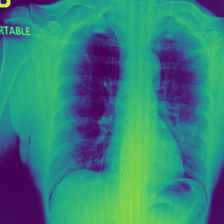

In [140]:
print(f"Class: {image_data.train[8][1]}")
image_data.train[8][0]

#TODO understand why it keeps changing. looks like the same photo, but augmented differently each time. maybe its the squish

# **Integrate image and tabular data**

In [141]:
integrate_train, integrate_val, integrate_test = get_imagetabdatasets(image_data, tab_data)

db = DataBunch.create(integrate_train, integrate_val, integrate_test, path=data_path, bs=batch_size)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7f31969d4210>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7f31969d4810>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7f31969d4bd0>

In [142]:
# TODO do we need this? I think it ruins the images, making them 3 channels again
# # image normalization with imagenet_stats
# db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
# db.add_tfm(db.norm)

In [143]:
x, y = next(iter(db.train_dl))

print(f"x holds {len(x)} items")
print(f"first item - batch of images ({x[0].shape})")
print(f"second item - holds both categorial ({x[1][0].shape}) and continuous ({x[1][1].shape}) tabular data")

print(f"y is the targets ({y.shape})")

x holds 2 items
first item - batch of images (torch.Size([64, 1, 224, 224]))
second item - holds both categorial (torch.Size([64, 8])) and continuous (torch.Size([64, 6])) tabular data
y is the targets (torch.Size([64]))


In [144]:
x, y = next(iter(db.train_dl))
y

tensor([0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 4, 4, 3, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3, 4, 2, 0, 0, 0, 0, 1, 2, 3, 0, 3, 0,
        0, 0, 0, 2, 3, 0, 1, 4, 0, 3, 0, 3, 0, 0, 0, 2])

# **The models**

### **The tabular model**

In [145]:
# embedding sizes of categorical data. Return the default embedding sizes suitable for this data. Using the rule of thumb - min(600, round(1.6 * n_cat**0.56))
# TODO think if we want to replace that with one-hot, since they are binary
emb_szs = tab_data.train.get_emb_szs()
print(f"emb_szs: {emb_szs}")

# The tabular model
tabular_model = TabularModel(emb_szs=emb_szs, n_cont = len(cont_names), out_sz=tab_out_sz, layers=tab_layers, ps=dropout_prob_tab)
tabular_model

emb_szs: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=18, bias=True)
  )
)

## **The CNN model** 
Using pretrained xrv.models.DenseNet for transfer learning

In [146]:
cnn_model = xrv.models.DenseNet(weights="densenet121-res224-all")
cnn_model.classifier

Linear(in_features=1024, out_features=18, bias=True)

In [147]:
# Don't backprop model parameters!
for param in cnn_model.parameters():
    param.requires_grad = False

In [148]:
#TODO check if this is necessary!

# # New classifier
# cnn_model.classifier = nn.Sequential(nn.Linear(1024, 512),
#                           nn.ReLU(),
#                           nn.Dropout(0.2),
#                           nn.Linear(512,256),
#                           nn.ReLU(),
#                           nn.Dropout(0.2),
#                           nn.Linear(256,18))

# #criterion = nn.NLLLoss()

# # Training only the classifier parameters, cnn_model parameters remains unchanged
# optimizer = optim.RMSprop(cnn_model.classifier.parameters(), lr=0.004)

## **The integrated CNN Tabular model** 

In [149]:
img_tabular_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = cnn_tabular_layers,
                                  ps=cnn_tabular_dropout_prob,
                                  out_sz=cnn_tabular_out_sz).to(device)

In [150]:
img_tabular_model

CNNTabularModel(
  (cnn_model): XRV-DenseNet121-densenet121-res224-all
  (tabular_model): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(3, 3)
      (2): Embedding(3, 3)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(3, 3)
      (7): Embedding(3, 3)
    )
    (emb_drop): Dropout(p=0.0, inplace=False)
    (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=30, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=100, out_features=200, bias=True)
      (5): ReLU(inplace=True)
      (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features

In [151]:
# check model output dimension, should be (batch_size, 5)
img_tabular_model(*x).shape

torch.Size([64, 5])

In [152]:
#TODO!! make the weigted loss work. we might need a list with len 5 and not 2

# # adjust loss function weight because the dataset is extremely unbalanced
# weights = [1/(1-train_df["severity_class"].mean()), 1/train_df["severity_class"].mean()]
# loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))
loss_func = CrossEntropyFlat()

In [153]:
# def accuracy_multi(preds, targs, thresh=0.5):
#     print(f"preds shape: {preds.shape} \n{preds}")
#     print(f"targs shape: {targs.shape} \n{targs}")
#     return ((preds>thresh)==targs).float().mean()

In [154]:
# learn = Learner(db, img_tabular_model, metrics=[accuracy, ROCAUC()], loss_func=torch.nn.NLLLoss)
# learn = Learner(db, img_tabular_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func) # <- TODO check why ROCAUC doesnt work
learn = Learner(db, img_tabular_model, metrics=[accuracy], loss_func=loss_func)

#TODO! check optimizer

In [155]:
learn.model

CNNTabularModel(
  (cnn_model): XRV-DenseNet121-densenet121-res224-all
  (tabular_model): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(3, 3)
      (2): Embedding(3, 3)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(3, 3)
      (7): Embedding(3, 3)
    )
    (emb_drop): Dropout(p=0.0, inplace=False)
    (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=30, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=100, out_features=200, bias=True)
      (5): ReLU(inplace=True)
      (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features

In [156]:
#TODO - check if we need this and if so, make this work

# # organize layer groups in order to use differential learning rates provided by fastai
# # the first two layer groups are earlier layers of resnet
# # the last layer group consists of the fully connected layers of cnn model, tabular model,
# # and final fully connected layers for the concatenated data
# learn.layer_groups = [nn.Sequential(*flatten_model(cnn_model.layer_groups[0])),
#                       nn.Sequential(*flatten_model(cnn_model.layer_groups[1])),
#                       nn.Sequential(*(flatten_model(cnn_model.layer_groups[2]) +
#                                       flatten_model(integrate_model.tabular_model) +
#                                       flatten_model(integrate_model.layers)))]

# **Training**

In [157]:
# TODO currently doesnt work. maybe because we don't have layer groups. check
# # find learning rate to train the last layer group first 
# learn.freeze()
# learn.lr_find()
# learn.recorder.plot()

In [158]:
# train
learn.fit_one_cycle(n_epoch, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.740784,1.629709,0.272727,01:13
1,1.791947,1.628106,0.272727,01:11


In [159]:
# # unfreeze all layer groups to train the entire model using differential learning rates
# learn.unfreeze()
# learn.fit_one_cycle(n_epoch, slice(1e-6, 1e-4))

# **Prediction**

In [160]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [161]:
#TODO!! understand why this is all nans
preds

tensor([[0.1746, 0.2171, 0.1949, 0.2427, 0.1707],
        [0.1771, 0.2146, 0.1961, 0.2418, 0.1704],
        [0.1754, 0.2130, 0.1963, 0.2444, 0.1709],
        [0.1756, 0.2137, 0.1965, 0.2439, 0.1703],
        [0.1754, 0.2135, 0.1965, 0.2439, 0.1707],
        [0.1756, 0.2135, 0.1960, 0.2449, 0.1699],
        [0.1756, 0.2126, 0.1968, 0.2420, 0.1731],
        [0.1755, 0.2137, 0.1965, 0.2438, 0.1705],
        [0.1757, 0.2136, 0.1961, 0.2446, 0.1700],
        [0.1755, 0.2137, 0.1965, 0.2437, 0.1705],
        [0.1763, 0.2130, 0.1964, 0.2449, 0.1695],
        [0.1754, 0.2130, 0.1963, 0.2444, 0.1709],
        [0.1755, 0.2130, 0.1962, 0.2443, 0.1710],
        [0.1756, 0.2137, 0.1965, 0.2438, 0.1704],
        [0.1756, 0.2137, 0.1965, 0.2439, 0.1703],
        [0.1754, 0.2131, 0.1964, 0.2443, 0.1708],
        [0.1756, 0.2134, 0.1962, 0.2439, 0.1709],
        [0.1757, 0.2138, 0.1962, 0.2442, 0.1702],
        [0.1757, 0.2129, 0.1960, 0.2439, 0.1714],
        [0.1754, 0.2130, 0.1963, 0.2444, 0.1709],


In [162]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [163]:
print(y.shape)
print(preds.shape)

torch.Size([28])
torch.Size([28, 5])


In [164]:
# for test_images, test_labels in trainloader:  
#     plt.imshow(test_images[0][0])
#     break

# **Explainability**

In [165]:
saliency_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                       transforms.RandomRotation(30),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5)),
                                       transforms.Lambda(lambda x: x[None])])
def create_saliency_map(image_filename='000001-17.jpg'):
  image = PIL.Image.open(f'/content/covid-chestxray-dataset/images/{image_filename}')
  image = train_transforms(image)
  image = image.reshape(1, 1, image_size, image_size)

  image.requires_grad_()
  output = model(image)

  # Catch the output
  output_idx = output.argmax()
  output_max = output[0, output_idx]

  # Do backpropagation to get the derivative of the output based on the image
  output_max.backward()

  saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
  saliency = saliency.reshape(image_size, image_size)

  # Reshape the image
  image = image.reshape(image_size, image_size)

  # Visualize the image and the saliency map
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(image.cpu().detach().numpy(), cmap="gray")
  ax[0].axis('off')
  ax[1].imshow(saliency.cpu(), cmap='hot')
  ax[1].axis('off')
  plt.tight_layout()
  fig.suptitle('The Image and Its Saliency Map')
  plt.show()

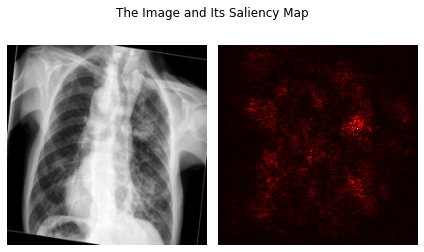

In [166]:
create_saliency_map()